## Imports

In [17]:
import numpy as np
import pandas as pd
from dx import *

## Purpose

We want to explore 3 well-known stochastic processes:
- geometric brownian motion
- jump diffusion
- square-root diffusion

## Functions

If you want to end up doing Monte Carlo simulations, you will need a way to generate random numbers with different distributions.
Note that we're generating distributions with variance reduction techniques like antithetic paths and moment matching.

In [2]:

def sn_random_numbers(shape, antithetic=True, moment_matching=True, fixed_seed=False):
        '''
        Returns array of shape shape with (pseudo)random numbers that are standard normally distributed.
        
        Parameters
        ==========
        shape : tuple (o, n, m)
            generation of array with shape (o, n, m)
        antithetic : Boolean
            generation of antithetic variates
        moment_matching : Boolean
            matching of first and second moments
        fixed_seed : Boolean
            flag to fix the seed
            
        Results
        =======
        ran : (o, n, m) array of (pseudo)random numbers
        '''
        if fixed_seed:
            np.random.seed(1000)
        if antithetic:
            ran = np.random.standard_normal((shape[0], shape[1], shape[2] / 2))
            ran = np.concatenate((ran, -ran), axis=2)
        else:
            ran = np.random.standard_normal(shape)
        if moment_matching:
            ran = ran - np.mean(ran)
            ran = ran / np.std(ran)
        if shape[0] == 1:
            return ran[0]
        else:
            return ran

In [3]:
snrn = sn_random_numbers((2, 2, 2,), antithetic=False, moment_matching=False, fixed_seed=True)

In [4]:
snrn

array([[[-0.8044583 ,  0.32093155],
        [-0.02548288,  0.64432383]],

       [[-0.30079667,  0.38947455],
        [-0.1074373 , -0.47998308]]])

In [5]:
snrn_mm = sn_random_numbers((2,3,2), antithetic=False, moment_matching=True, fixed_seed=True)

In [6]:
snrn_mm

array([[[-1.47414161,  0.67072537],
        [ 0.01049828,  1.28707482],
        [-0.51421897,  0.80136066]],

       [[-0.14569767, -0.85572818],
        [ 1.19313679, -0.82653845],
        [ 1.3308292 , -1.47730025]]])

In [7]:
snrn_mm.mean()

3.700743415417188e-17

In [8]:
snrn_mm.std()

1.0

## Generic Simulation Class

In [15]:
class simulation_class(object):
    '''
    Base methods for simulation classes
    
    Attributes
    ==========
    name : string
        name of object
    mar_env : instance of market_environment
        market environment data for simulation
    corr : Boolean
        True if correlated with other model object
        
    Methods
    =======
    generate_time_grid :
        returns time grid for simulation
    get_instrument_values : 
        returns current instrument values (array)
    '''
    
    def __init__(self, name, mar_env, corr):
        try:
            self.name = name
            self.pricing_date = mar_env.pricing_date
            self.initial_value = mar_env.get_constant('initial_value')
            self.volatility = mar_env.get_constant('volatility')
            self.final_date = mar_env.get_constant('final_date')
            self.currency = mar_env.get_constant('currency')
            self.frequency = mar_env.get_constant('frequency')
            self.paths = mar_env.get_constant('paths')
            self.discount_curve = mar_env.get_curve('discout_curve')
            try:
                # if time_grid in mar_env take this
                # (for portfolio valuation)
                self.time_grid = mar_env.get_list('time_grid')
            except:
                self.time_grid = None
            try:
                # if special dates exist, add them
                self.special_dates = mar_env.get_list('special_dates')
            except:
                self.special_dates = []
            self.instrument_values = None
            self.correlated = corr
            if corr is True:
                # only necessary in portfolio context when
                # risk factors are correlated
                self.cholesky_matrix = mar_env.get_list('cholesky_matrix')
                self.rn_set = mar_env.get_list('rn_set')[self.name]
                self.random_numbers = mar_env.get_list('random_numbers')
        except:
                print("Error parsing market environment")
    
    def generate_time_grid(self):
        start = self.pricing_date
        end = self.final-date
        # pandas date_range function
        # freq = 'B' for business day
        # 'W' for weekly, 'M' for monthly
        time_grid = pd.date_range(start=start, end=end
                                  , freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        # enhance time_grid by start, end, and special_dates
        if start not in time_grid:
            time_grid.insert(0, start)
            # insert start date if not in list
        if end not in time_grid:
            time_grid.append(end)
            # insert end date if not in list
        if len(self.special_dates) > 0:
            # add all special dates
            time_grid.extend(self.special_dates)
            # delete duplicates
            time_grid = list(set(time_grid))
            # sort list
            time_grid.sort()
        self.time_grid = np.array(time_grid)
        
    def get_instrument_values(self, fixed_seed=True):
        if self.instrument_values is None:
            # only initiate simulation if no instrument values exist
            self.generate_paths(fixed_seed=fixed_seed, day_count=365)
        elif fixed_seed is False:
            # also initiate resimulation when fixed_seed is False
            self.generate_paths(fixed_seed=fixed_seed, day_count=365)
        return self.instrument_values

# Geometric Brownian Motion

## Simulation Class

In [16]:
class geometric_brownian_motion(simulation_class):
    """
    Class to generate simulated paths based on the Black-Scholes-Merton geometric
    Brownian motion model.
    
    Attributes
    ==========
    name : string
        name of the object
    mar_env : instance of market_environment
        market environment data for simulation
    corr : Boolean
        True if correlated  with other model simulation object
        
    Methods
    =======
    update : 
        updates paramters
    generate_paths :
        returns Monte Carlo paths given market environment
    """
    
    def __init__(self, name, mar_env, corr=False):
        super(geometric_brownian_motion, self).__init__(name, mar_env, corr)
        
    def update(self, initial_value=None, volatility=None, final_date=None):
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None
    
    def generate_paths(self, fixed_seed=False, day_count=365):
        if self.time_grid is None:
            self.generate_time_grid()
            # method from generic simulation class
        # number of dates for time grid
        M = len(self.time_grid)
        # number of paths
        I = self.paths
        # array initialization for path simulation
        paths = np.zeros((M, I))
        # initialize first date with initial_value
        paths[0] = self.initial_value
        if not self.correlated:
            # if not correlated, generate random numbers
            rand = sn_random_numbers((1, M, I), fixed_seed=fixed_seed)
        else:
            # if correlated, use random number object as provided
            # in market environment
            rand = self.random_Numbers
        short_rate = self.discount_curve.short_rate
        # get short rate for drift of process
        for t in range(1, len(self.time_grid)):
            # select right time slice from relevant
            # random number set
            if not self.correlated:
                ran = rand[t]
            else:
                ran = npo.dot(self.cholesky_matrix, rand[:, t, :])
                ran = ran[self.rn_set]
            dt = (self.time_grid[t] - self.time_grid[t-1]).days / day_count
            # difference between two dates as year fraction
            paths[t] = paths[t-1] * np.exp((short_rate - 0.5 * self.volatility ** 2) * dt +
                                           self.volatility * np.sqrt(dt) * ran)
            # generate simulated values for the respective date
        self.instrument_values = paths

In [18]:
me_gbm = market_environment('me_gbm', dt.datetime(2015, 1, 1))

In [20]:
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2015, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
me_gbm.add_constant('paths', 1000)

In [21]:
csr = constant_short_rate('csr', 0.05)

In [22]:
me_gbm.add_curve('discount_curve', csr)

In [24]:
gbm = geometric_brownian_motion('gbm', me_gbm)

In [25]:
gbm.generate_time_grid()

In [26]:
gbm.time_grid

array([datetime.datetime(2015, 1, 1, 0, 0),
       datetime.datetime(2015, 1, 31, 0, 0),
       datetime.datetime(2015, 2, 28, 0, 0),
       datetime.datetime(2015, 3, 31, 0, 0),
       datetime.datetime(2015, 4, 30, 0, 0),
       datetime.datetime(2015, 5, 31, 0, 0),
       datetime.datetime(2015, 6, 30, 0, 0),
       datetime.datetime(2015, 7, 31, 0, 0),
       datetime.datetime(2015, 8, 31, 0, 0),
       datetime.datetime(2015, 9, 30, 0, 0),
       datetime.datetime(2015, 10, 31, 0, 0),
       datetime.datetime(2015, 11, 30, 0, 0),
       datetime.datetime(2015, 12, 31, 0, 0)], dtype=object)

In [27]:
%time paths_1 = gbm.get_instrument_values()

CPU times: total: 0 ns
Wall time: 1 ms


In [28]:
paths_1

array([[36.        , 36.        , 36.        , ..., 36.        ,
        36.        , 36.        ],
       [35.78945389, 39.05154208, 36.9925551 , ..., 35.70726278,
        35.4146262 , 36.15973232],
       [35.79998061, 36.8598076 , 39.74466161, ..., 38.13444314,
        35.21752262, 37.740815  ],
       ...,
       [37.35366767, 40.00483388, 31.21209548, ..., 51.6090017 ,
        34.48523426, 32.44983244],
       [36.26059903, 39.54765646, 32.92089923, ..., 49.60653363,
        36.07857857, 32.72804212],
       [36.35137867, 41.31311565, 31.1258676 , ..., 50.03170774,
        38.59692377, 30.49907394]])

In [29]:
gbm.update(volatility=0.5)

In [30]:
%time paths_2 = gbm.get_instrument_values()

CPU times: total: 0 ns
Wall time: 387 µs


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([16436., 16495., 16556., 16617., 16679., 16740., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

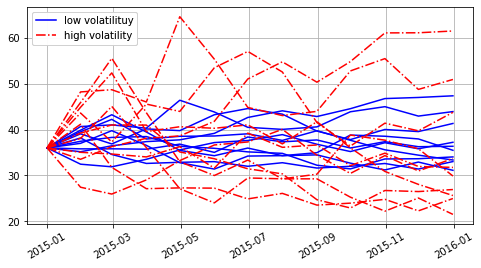

In [34]:
plt.figure(figsize=(8,4))
p1 = plt.plot(gbm.time_grid, paths_1[:, :10], 'b')
p2 = plt.plot(gbm.time_grid, paths_2[:, :10], 'r-.')
plt.grid(True)
l1 = plt.legend([p1[0], p2[0]], ['low volatilituy', 'high volatility'], loc=2)
plt.gca().add_artist(l1)
plt.xticks(rotation=30)